In [103]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import pearsonr, spearmanr

# Arial font
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

import statsmodels.formula.api as smf

float_format = lambda x: '%.3f' % x

# Define any additional metrics to add to the stats df, e.g. fantasy points
def add_metrics(df):
    df['agg_score'] = 1*df['PTS'] + 1.2*df['TRB'] + 1.5*df['AST'] + 2*df['BLK'] + 2*df['STL'] - 1*df['TOV']
    df['log2_mentions'] = np.log2(df['insta_mentions'])
    return df

In [104]:
path = './data/202324_instagram_counts_and_stats.csv'
df = pd.read_csv(path, index_col=0).reset_index()
df = add_metrics(df)
display(df.head(10))

df_nonzero = df[df['insta_mentions'] > 0].copy()
display(df_nonzero.head(10))

/Users/rajivmovva/miniconda3/envs/llm/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,player,insta_mentions,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV,agg_score,log2_mentions
0,A.J. Green,0,MIL,19.0,7.7,3.2,0.8,0.7,0.0,0.0,0.438,0.625,0.0,5.21,-inf
1,A.J. Lawson,0,DAL,11.0,8.3,3.5,0.7,0.4,0.4,0.1,0.469,0.531,0.5,5.44,-inf
2,AJ Griffin,0,ATL,12.0,9.2,2.5,1.0,0.3,0.1,0.0,0.294,0.412,0.3,4.05,-inf
3,Aaron Gordon,9,DEN,26.0,32.0,13.5,6.9,3.5,1.0,0.6,0.522,0.544,1.4,28.83,3.169925
4,Aaron Holiday,1,HOU,24.0,18.1,7.0,1.9,1.7,0.5,0.1,0.453,0.566,0.6,12.43,0.000000
5,Aaron Nesmith,2,IND,25.0,24.7,11.9,3.1,1.0,1.0,0.8,0.540,0.668,0.7,20.02,1.000000
6,Aaron Wiggins,0,OKC,24.0,12.4,5.2,2.2,0.7,0.5,0.0,0.595,0.671,0.5,9.39,-inf
7,Admiral Schofield,0,ORL,8.0,3.5,0.9,0.6,0.3,0.0,0.0,0.300,0.350,0.5,1.57,-inf
8,Al Horford,3,BOS,23.0,26.7,7.7,7.1,2.8,0.4,1.0,0.472,0.585,1.0,22.22,1.584963
9,Alec Burks,0,DET,21.0,17.5,9.0,2.1,1.4,0.4,0.2,0.329,0.429,0.4,14.42,-inf


,player,insta_mentions,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV,agg_score,log2_mentions
3,Aaron Gordon,9,DEN,26.0,32.0,13.5,6.9,3.5,1.0,0.6,0.522,0.544,1.4,28.83,3.169925
4,Aaron Holiday,1,HOU,24.0,18.1,7.0,1.9,1.7,0.5,0.1,0.453,0.566,0.6,12.43,0.000000
5,Aaron Nesmith,2,IND,25.0,24.7,11.9,3.1,1.0,1.0,0.8,0.540,0.668,0.7,20.02,1.000000
8,Al Horford,3,BOS,23.0,26.7,7.7,7.1,2.8,0.4,1.0,0.472,0.585,1.0,22.22,1.584963
11,Alex Caruso,7,CHI,24.0,23.1,9.5,3.4,2.3,1.3,0.8,0.553,0.677,1.5,19.73,2.807355
14,Alperen Sengun,18,HOU,26.0,31.7,19.8,9.2,5.2,0.9,0.8,0.533,0.556,2.5,39.54,4.169925
16,Amen Thompson,1,HOU,7.0,15.3,5.4,3.4,1.6,0.4,0.1,0.429,0.457,1.3,11.58,0.000000
18,Andre Drummond,1,CHI,30.0,13.5,6.4,6.8,0.6,1.1,0.4,0.514,0.514,1.0,17.46,0.000000
20,Andrew Nembhard,3,IND,18.0,18.0,6.9,1.7,3.9,0.9,0.1,0.458,0.504,1.3,15.49,1.584963
21,Andrew Wiggins,4,GSW,25.0,26.6,12.3,4.6,1.1,0.3,0.4,0.420,0.463,1.7,19.17,2.000000


### predicting any mentions (binary)

In [105]:
df['any_mentions'] = (df['insta_mentions'] > 0).astype(int)

# Regress any_mentions on PTS using statsmodels OLS
model = smf.logit('any_mentions ~ agg_score', data=df)
res = model.fit()
print(res.summary())

# How much predictive power do you have?
y_pred_prob = res.predict(df)
print("Mean predicted prob", float_format(np.mean(y_pred_prob)), 
      "Actual mean", float_format(np.mean(df['any_mentions'])))

thresh = 0.5
print("@ threshold", thresh)
y_pred = (y_pred_prob > thresh).astype(int)

print('Accuracy:', float_format(metrics.accuracy_score(df['any_mentions'], y_pred)))
print('Precision:', float_format(metrics.precision_score(df['any_mentions'], y_pred)))
print('Recall:', float_format(metrics.recall_score(df['any_mentions'], y_pred)))

Optimization terminated successfully.
         Current function value: 0.410431
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           any_mentions   No. Observations:                  509
Model:                          Logit   Df Residuals:                      507
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Dec 2023   Pseudo R-squ.:                  0.4021
Time:                        01:40:30   Log-Likelihood:                -208.91
converged:                       True   LL-Null:                       -349.38
Covariance Type:            nonrobust   LLR p-value:                 4.659e-63
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2979      0.284    -11.602      0.000      -3.855      -2.741
agg_score      0.1902      0.

In [106]:
# Print people with highest predicted probability of having a mention who don't have any
df_mention_probs = df.copy()
df_mention_probs['mention_prob'] = y_pred_prob
df_mention_probs.sort_values('mention_prob', ascending=False, inplace=True)
display(df_mention_probs[df_mention_probs['any_mentions'] == 0].head(10))

,player,insta_mentions,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV,agg_score,log2_mentions,any_mentions,mention_prob
22,Anfernee Simons,0,POR,9.0,34.1,27.1,3.1,5.9,0.9,0.1,0.457,0.538,2.6,39.07,-inf,0,0.984217
258,Jonas Valanciunas,0,NOP,29.0,27.7,14.8,9.8,2.5,0.5,1.3,0.577,0.615,1.4,32.51,-inf,0,0.947111
455,Spencer Dinwiddie,0,BRK,27.0,31.9,14.4,4.0,6.6,0.9,0.2,0.405,0.495,1.7,29.60,-inf,0,0.911474
349,Mark Williams,0,CHO,19.0,26.7,12.7,9.7,1.2,0.8,1.1,0.649,0.649,0.9,29.04,-inf,0,0.902495
168,Gordon Hayward,0,CHO,23.0,32.3,15.0,4.7,4.7,1.1,0.4,0.468,0.507,2.0,28.69,-inf,0,0.896479
122,Dennis Schroder,0,TOR,28.0,32.0,14.4,2.8,6.8,1.0,0.1,0.421,0.488,1.7,28.46,-inf,0,0.892348
341,Malcolm Brogdon,0,POR,20.0,27.4,15.1,3.5,5.4,0.8,0.2,0.419,0.498,1.5,27.90,-inf,0,0.881681
65,Caris LeVert,0,CLE,22.0,29.3,15.1,3.6,3.7,1.1,0.4,0.414,0.479,1.5,26.47,-inf,0,0.850238
491,Tyus Jones,0,WAS,28.0,27.6,12.3,3.0,5.4,1.2,0.3,0.537,0.611,0.8,26.20,-inf,0,0.843581
41,Bojan Bogdanovic,0,DET,9.0,31.8,19.7,2.1,2.3,1.0,0.1,0.473,0.578,1.8,26.07,-inf,0,0.840291


### regress number of mentions for people with mentions

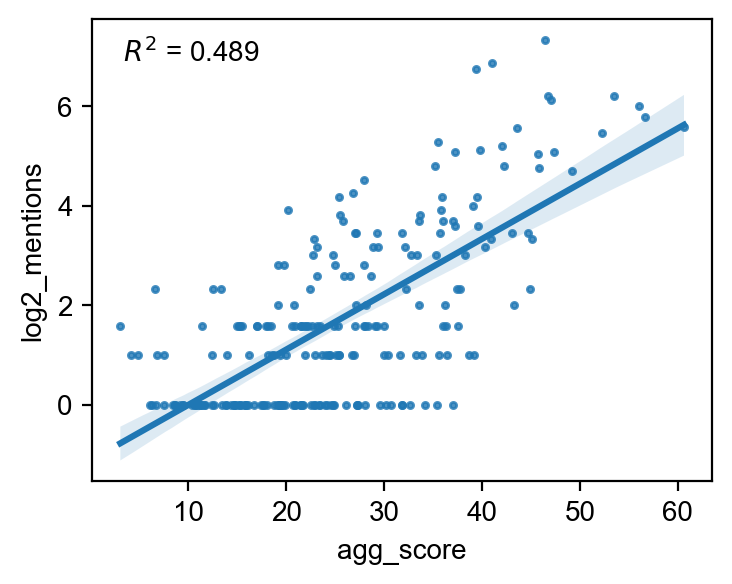

In [114]:
# Do an sns.regplot of np.log2(insta_mentions) against agg_score
import seaborn as sns
plt.figure(figsize=(4,3), dpi=200)

x_col = 'agg_score'
y_col = 'log2_mentions'
# y_col = 'insta_mentions'

sns.regplot(x=x_col, y=y_col, 
            data=df_nonzero, scatter_kws={'s': 5})

# Annotate the plot with R^2 in top-left
r = pearsonr(df_nonzero[x_col], df_nonzero[y_col])[0]
plt.text(0.05, 0.91, '$R^2$ = ' + float_format(r*r), transform=plt.gca().transAxes)

plt.show()

In [115]:
# Regress any_mentions on PTS using statsmodels OLS
model = smf.ols(f'{y_col} ~ {x_col}', data=df_nonzero)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          log2_mentions   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     213.5
Date:                Mon, 25 Dec 2023   Prob (F-statistic):           2.30e-34
Time:                        01:45:08   Log-Likelihood:                -374.31
No. Observations:                 225   AIC:                             752.6
Df Residuals:                     223   BIC:                             759.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1157      0.212     -5.261      0.0

In [119]:
# Print the players with the largest residuals
df_nonzero['resid'] = res.resid
df_nonzero['expected_mentions'] = res.predict(df_nonzero)
if y_col == 'log2_mentions':
    df_nonzero['expected_mentions'] = 2**df_nonzero['expected_mentions']

df_nonzero.sort_values('resid', ascending=False, inplace=True)
show_stats = [
    'player', 'Tm', 'agg_score', 'insta_mentions', 'expected_mentions', 'resid', 'PTS', 'TRB', 'AST', 'BLK', 'STL', 'TOV'
]
print("Players with too many mentions:")
display(df_nonzero[show_stats].head(10))

print("Players with too few mentions:")
display(df_nonzero[show_stats].tail(10)[::-1])

print("All popular players:")
display(df_nonzero[df_nonzero['insta_mentions'] > 20][show_stats].sort_values('resid', ascending=False))


Players with too many mentions:


,player,Tm,agg_score,insta_mentions,expected_mentions,resid,PTS,TRB,AST,BLK,STL,TOV
457,Stephen Curry,GSW,39.39,107,9.603441,3.477916,28.3,4.7,4.5,0.3,0.7,3.3
495,Victor Wembanyama,SAS,41.04,117,10.905582,3.423370,18.5,10.7,2.8,3.0,1.4,3.3
326,LeBron James,LAL,46.39,160,16.470319,3.280132,25.2,7.7,7.3,0.7,1.5,3.4
394,Obi Toppin,IND,20.15,15,2.180243,2.782402,12.4,3.5,1.3,0.6,0.6,0.8
233,Jaxson Hayes,LAL,6.55,5,0.764437,2.709458,3.1,2.0,0.3,0.4,0.2,0.6
29,Austin Reaves,LAL,27.99,23,3.989267,2.527438,15.3,4.7,4.9,0.1,1.0,2.5
344,Malik Monk,SAC,25.42,18,3.272507,2.459529,14.3,2.6,5.2,0.6,0.6,2.2
70,Chet Holmgren,OKC,35.53,39,7.132485,2.450997,17.2,7.9,2.5,2.7,0.8,1.9
434,Russell Westbrook,LAC,26.80,19,3.639706,2.384106,11.3,6.5,4.6,0.5,1.1,2.4
265,Jordan McLaughlin,MIN,3.05,3,0.583720,2.361615,0.9,0.0,0.9,0.3,0.1,0.0


Players with too few mentions:


,player,Tm,agg_score,insta_mentions,expected_mentions,resid,PTS,TRB,AST,BLK,STL,TOV
488,Tyler Herro,MIA,37.06,1,8.025031,-3.004507,24.2,5.3,4.4,0.0,1.3,2.7
390,Nikola Vucevic,CHI,35.36,1,7.039654,-2.815505,16.6,10.3,3.4,0.7,0.8,1.7
156,Franz Wagner,ORL,34.16,1,6.417854,-2.682091,20.1,5.8,4.0,0.3,1.1,1.7
286,Jusuf Nurkic,PHO,32.61,1,5.695274,-2.509765,12.1,10.3,3.9,1.2,1.0,2.1
61,Cam Thomas,BRK,31.82,1,5.358892,-2.421935,24.1,3.1,2.4,0.5,0.6,1.8
241,Jerami Grant,POR,31.81,1,5.354764,-2.420823,22.6,3.8,2.5,0.8,0.8,2.3
208,Jalen Duren,DET,30.73,1,4.927142,-2.300751,12.6,10.9,2.5,1.4,0.6,2.7
118,Deandre Ayton,POR,30.20,1,4.729956,-2.241827,13.1,11.0,1.6,0.7,1.1,2.1
466,Terry Rozier,CHO,39.19,2,9.456562,-2.241316,23.2,3.7,7.1,0.4,1.2,2.3
129,Desmond Bane,MEM,38.70,2,9.106134,-2.186839,24.7,4.5,5.2,0.7,1.2,3.0


All popular players:


,player,Tm,agg_score,insta_mentions,expected_mentions,resid,PTS,TRB,AST,BLK,STL,TOV
457,Stephen Curry,GSW,39.39,107,9.603441,3.477916,28.3,4.7,4.5,0.3,0.7,3.3
495,Victor Wembanyama,SAS,41.04,117,10.905582,3.423370,18.5,10.7,2.8,3.0,1.4,3.3
326,LeBron James,LAL,46.39,160,16.470319,3.280132,25.2,7.7,7.3,0.7,1.5,3.4
29,Austin Reaves,LAL,27.99,23,3.989267,2.527438,15.3,4.7,4.9,0.1,1.0,2.5
70,Chet Holmgren,OKC,35.53,39,7.132485,2.450997,17.2,7.9,2.5,2.7,0.8,1.9
301,Kevin Durant,PHO,46.74,74,16.920600,2.128745,30.9,6.2,5.4,1.1,0.8,3.5
223,James Harden,LAC,37.21,34,8.118334,2.066279,17.4,4.8,7.7,0.9,1.5,2.3
489,Tyrese Haliburton,IND,47.10,70,17.396593,2.008550,24.3,4.0,12.0,0.6,0.8,2.8
235,Jaylen Brown,BOS,35.21,28,6.958748,2.008527,22.7,4.8,3.7,0.7,1.1,2.4
238,Jayson Tatum,BOS,43.54,47,13.222652,1.829649,26.8,8.7,4.2,0.5,1.0,3.0
